# Model_comparison: checking for model quality

This is the code is adapted from [Bayesian Analysis with Python](https://github.com/aloctavodia/BAP).


In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Overfitting vs underfitting

Text(0,0.5,'$y$')

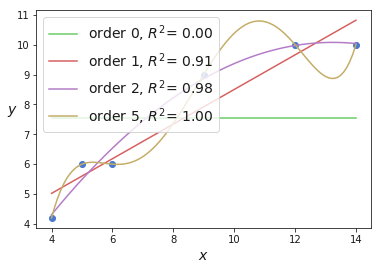

In [2]:
x = np.array([4.,5.,6.,9.,12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2) 
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label='order {}, $R^2$= {:.2f}'.format(i, r2))

plt.legend(loc=2, fontsize=14)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14, rotation=0)



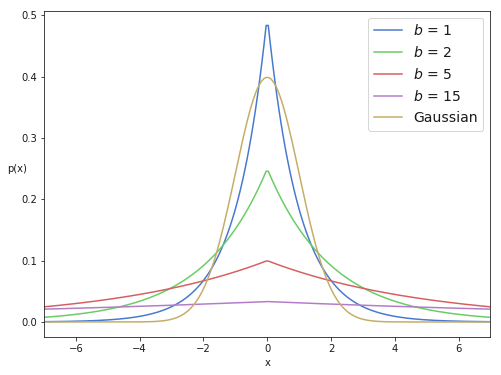

In [3]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 300)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label='$b$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.ylabel('p(x)', rotation=0)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);


In [4]:
x_1 = np.array([ 10.,   8.,  13.,   9.,  11.,  14.,   6.,   4.,  12.,   7.,   5.])
y_1 = np.array([  8.04,   6.95,   7.58,   8.81,   8.33,   9.96,   7.24,   4.26,
        10.84,   4.82,   5.68])

In [5]:
np.random.seed(1)
real_alpha = 4.25
real_beta = [8.7, -1.2]
data_size = 20
noise = np.random.normal(0, 2, size=data_size)
x_1 = np.linspace(0, 5, data_size)
y_1 = real_alpha + real_beta[0] * x_1 + real_beta[1] * x_1**2 + noise

Text(0,0.5,'$y$')

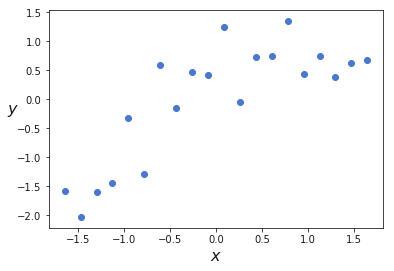

In [6]:
order = 2#5
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))/x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean())/y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)


In [7]:
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta * x_1s[0]
    
    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_l = pm.sample(2100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
 96%|█████████▌| 2490/2600 [00:02<00:00, 1131.46it/s]/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.8805638797040319, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2600/2600 [00:02<00:00, 1141.89it/s]


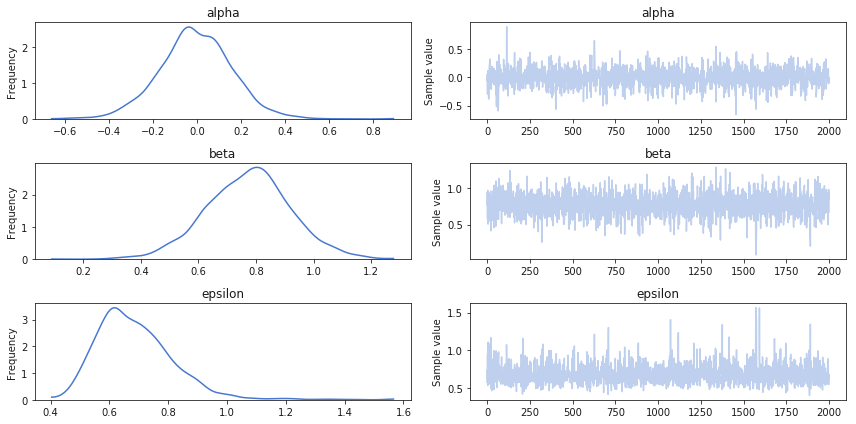

In [8]:
chain_l = trace_l[100:]
pm.traceplot(chain_l);

In [9]:
pm.df_summary(chain_l)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-0.004244,0.163702,0.004381,-0.349539,0.294595
beta,0.770204,0.148279,0.003150,0.486822,1.071365
epsilon,0.689603,0.131352,0.003605,0.477251,0.926601


In [10]:
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=x_1s.shape[0])  
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, x_1s)
    
    y_l = pm.Normal('y_l', mu=mu, sd=epsilon, observed=y_1s)
    
    trace_p = pm.sample(2100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
 99%|█████████▉| 2573/2600 [00:04<00:00, 598.95it/s]/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.8835699874312559, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2600/2600 [00:04<00:00, 598.61it/s]


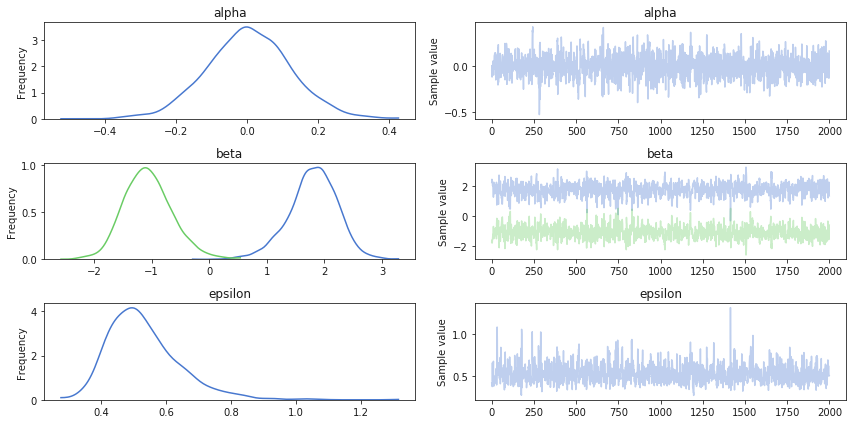

In [11]:
chain_p = trace_p[100:]
pm.traceplot(chain_p);

In [12]:
pm.df_summary(chain_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.002728,0.119312,0.003068,-0.227548,0.235963
beta__0,1.790497,0.420584,0.015532,0.899142,2.558029
beta__1,-1.059233,0.420672,0.015888,-1.872152,-0.229679
epsilon,0.532563,0.110724,0.003692,0.338132,0.747471


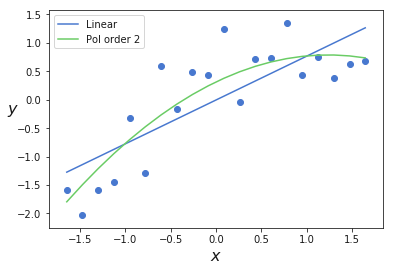

In [13]:
alpha_l_post = chain_l['alpha'].mean()
betas_l_post = chain_l['beta'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_l_post = alpha_l_post + betas_l_post * x_1s[0]

plt.plot(x_1s[0][idx], y_l_post[idx], label='Linear')


alpha_p_post = chain_p['alpha'].mean()
betas_p_post = chain_p['beta'].mean(axis=0)
y_p_post = alpha_p_post + np.dot(betas_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], label='Pol order {}'.format(order))

plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0);
plt.legend()


# Information criteria

In [14]:
dic_l = pm.dic(trace=trace_l, model=model_l)
dic_l

57.110162591156424

In [15]:
dic_p = pm.dic(trace=trace_p, model=model_p)
dic_p

54.116089307855525

In [16]:
waic_l = pm.waic(trace=trace_l, model=model_l)
waic_l

WAIC_r(WAIC=42.636853356970775, WAIC_se=4.114700456916793, p_WAIC=2.134039461160734)

In [17]:
waic_p = pm.waic(trace=trace_p, model=model_p)
waic_p

WAIC_r(WAIC=32.88754311537928, WAIC_se=4.5947581127147155, p_WAIC=2.700278760825131)

In [18]:
loo_l = pm.loo(trace=trace_l, model=model_l)
loo_l

/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=42.832385235141714, LOO_se=4.174422805892544, p_LOO=2.231805400246202)

In [19]:
loo_p = pm.loo(trace=trace_p, model=model_p)
loo_p

/home/ohalloranb/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO_r(LOO=33.0884642856551, LOO_se=4.655839704551458, p_LOO=2.8007393459630414)

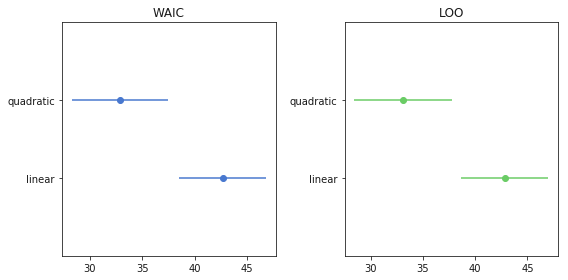

In [20]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
for idx, ic in enumerate((waic_l, waic_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='bo')
plt.title('WAIC')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.subplot(122)
for idx, ic in enumerate((loo_l, loo_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='go')
plt.title('LOO')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.tight_layout()



## Posterior predictive checks

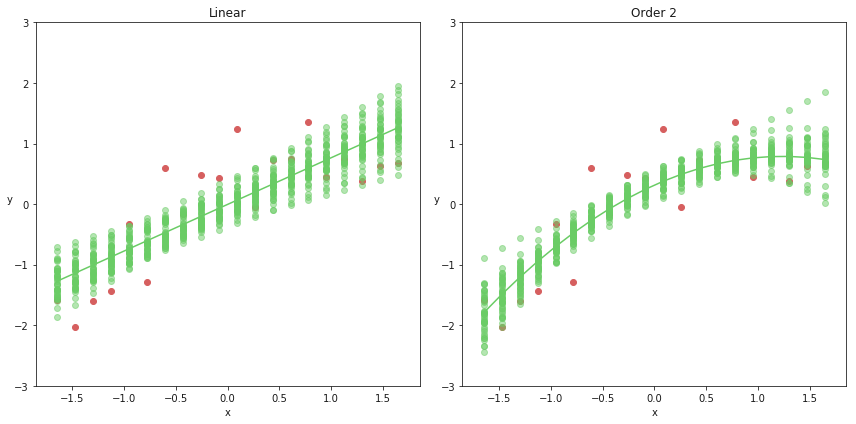

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x_1s[0], y_1s, c='r');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Linear')


for i in range(0, len(chain_l['alpha']), 50):
    plt.scatter(x_1s[0], chain_l['alpha'][i] + chain_l['beta'][i]*x_1s[0], c='g',
                edgecolors='g', alpha=0.5);
plt.plot(x_1s[0], chain_l['alpha'].mean() + chain_l['beta'].mean()*x_1s[0], c='g', alpha=1)

    
plt.subplot(122)
plt.scatter(x_1s[0], y_1s, c='r');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Order {}'.format(order))
for i in range(0, len(chain_p['alpha']), 50):
    plt.scatter(x_1s[0], chain_p['alpha'][i] + np.dot(chain_p['beta'][i], x_1s), c='g',
                edgecolors='g', alpha=0.5)
idx = np.argsort(x_1)
plt.plot(x_1s[0][idx], alpha_p_post + np.dot(betas_p_post, x_1s)[idx], c='g', alpha=1);

plt.tight_layout()


In [26]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a x86_64 computer running Fedora 28 and using:
Python 3.6.3
IPython 6.1.0
PyMC3 3.2
NumPy 1.14.2
SciPy 1.0.0
Matplotlib 2.1.2
Seaborn 0.8.0
